# 0. Abstract and Outline

The purpose of this document is to give a gentle introduction to logistic regression and its application to predicting long-term user retention at Kwai. Logistic regression is arguably the simplest model used in classification. Besides its simplicity and scalability, another important advantage of logistic regression is that this is a generalized linear model so that it is well interpretable. Both the modeling details, the case study, and the Python code are included in this document. 

Below is the outline of this document:

- In [Section 1](#section_1), we discuss, from a mathematical perspective, the purpose and formulation of a classification problem.

- In [Section 2](#section_2), we introduce the logistic regression model and its estimation approach.

- In [Section 3](#section_3), we present the case study of using short-term consumption data to predict long-term retention of a large-scale video-sharing platform Kwai. We also preprocess Kwai's data and fit a logistic regression model on the training set.

- In [Section 4](#section_4), we discuss how to convert the regression results into classification predictions, and introduce different in-sample metrics (e.g., accuracy, false-negative, false-positive, ROC, AUC, etc.) to evaluate model fitness. We also apply the fitted logistic regression model to analyze Kwai's data.

- In [Section 5](#section_5), we generalize the in-sample metrics to out-of-sample ones and apply them to Kwai's data.

- In [Section 6](#section_6), we re-interpret the logistic regression from a latent variable perspective.

- In [Section 7](#section_7), we discuss the general linearity of the logistic regression model and how such linearity could help tradeoff different consumption metrics at Kwai.

- In [Section 8](#section_8), we briefly introduce how to design a metric based on the logistic regression model, and the backtest rationale of metric based on A/B tests.

<a id='section_1'></a>
# 1. Classification in a Nutshell

Along with regression, classification is one of two types of supervised learning. The goal of classification is to identify the relationship between features $X=(X_1,X_2,...,X_p)'$ and the outcome $Y$, which is a categorical variable. For simplicity, we assume $Y\in\{0,1\}$ in this document, i.e., we consider a binary classification. Eventually, we seek to address the prediction of lable $Y$ given a feature vector $X$. 


Typical examples of a classification problem include to predict:
  
- Whether a user will watch a movie on Netflix;
- Whether a user will click an advertisement on Kwai;
- Whether a patient has lung cancer.


In a lot of circumstances, linear regression cannot be used to address a classification problem. This is because, for a classification problem with discrete outcomes, the data is inherently generated in a non-linear fashion, as illustrated by the following figure. 


<img src="illustration.png" width=500>


A linear regression model will produce some misleading results.


To be more specific, we seek to build a classifier $\hat f(\cdot)$ based on the training data set $\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$ that predicts the ourcome $Y$ from feature $X$ of the following form:

<font color=red>
    
$$Y_i\approx\hat Y_i:=\hat f(X_i)=\begin{cases}
1,\mbox{ if }X_i\in\mathcal X\\
0,\mbox{ otherwise}
\end{cases}
\mbox{ for all }i=1,2,...,n
$$
</font>

Here, $\approx$ refers to "as close as possible" and $\mathcal X$ is a set of features with which the classifier $\hat f(\cdot)$ will predict $Y=1$. In this course, we use the notation $\hat{}$ to represent what is generated from data. At a high level, we train our classifier $\hat f(\cdot)$ to make as few mistakes as possible (on the training set), i.e., the total number/proportion of mistakes is as small as possible:

$$\frac{1}{n}\sum_{i=1}^n1\{\hat f(X_i)\ne Y_i\}\mbox{ is minimized, where }1\{\hat f(X_i)\ne Y_i\}=\begin{cases}
1,\mbox{ if }\hat f(X_i)\ne Y_i\\
0,\mbox{ otherwise}
\end{cases}
$$



<a id='section_2'></a>
# 2. Logistic Regression Model

The __logistic regression__ model transforms a classification problem into a regression problem. Specifically, we attempt to predict the conditional probability of the outcome $Y$ being positive given the feature $X$, which we denote as:

$$\mathbb{P}[Y=1|X]$$

Here, $\mathbb P[A|B]$ means the conditional probability of event $A$ given that event $B$ happens ([Wiki Page](https://en.wikipedia.org/wiki/Conditional_probability)).

As discussed above, the input of logistic regression is the training set $\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$ and the output is a fitted model $\hat g(\cdot)$ which predicts the probability of positive outcome for each data point in $\mathcal D$:

<font color=red>
    
$$\hat g(X_i)\approx \mathbb P[Y_i=1|X_i],\mbox{ where }X_i=(X_{i1},X_{i2},...,X_{ip}),\mbox{ for each }i=1,2,...,n$$

</font>
    
Specifically, the logistic regression model assumes the following underlying distribution that generates the data:

<font color=red>

$$\mathbb P[Y_i=1|X_i]=\frac{\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}$$

</font>

thus

$$\mathbb P[Y_i=0|X_i]=1-\mathbb P[Y_i=1|X_i]=\frac{1}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}$$

We usually call the function 

<font color=red>
$$S(x)=\frac{\exp(x)}{1+\exp(x)}$$ 
</font>

as the sigmoid function ([Wiki Page](https://en.wikipedia.org/wiki/Sigmoid_function)). The logistic regression model can therefore be written as $\mathbb P[Y_i=1|X_i]=S(\beta_0+\sum_{j=1}^p\beta_jX_{ij})$. We could plot the sigmoid function, which is also single-variable logistic regression model ($p=1$) with $\beta_0=0$ and $\beta_1=1$, as in the following figure:

<img src="LR-figure.png" width=500>

There are a few properties worth noticing with respect to the sigmoid function and logistic regression:

- The sigmoid function is increasing in $x$, which implies that larger values of the features with postive (respectively negative) coefficients will tend to increase the probability that $Y=1$ (respectively $Y=0$). 
- Positive (respectively negative) values of $\beta_0+\sum_{j=1}^p\beta_jX_{ij}$ are predictive of $Y_i=1$ (respectively $Y_i=0$), i.e., $\mathbb P[Y_i=1|X]>0.5$ if $\beta_0+\sum_{j=1}^p\beta_jX_{ij}>0$ and $\mathbb P[Y_i=1|X]<0.5$ if $\beta_0+\sum_{j=1}^p\beta_jX_{ij}<0$.
- The sigmoid function is increasing linearly when $x$ is close to 0 and is very flat when $x$ is far away from 0 (for example $|x|\ge 4$).

In statistics or gambling, we use odds ([Wiki Page](https://en.wikipedia.org/wiki/Odds#Fractional_odds)) to measure the likelihood of a particular outcome. Specifically, for the logistic regression model, we calculate the odds of $Y_i=1$ as the ratio between the probability of $Y_i=1$ given feature $X_i$ and the probability of $Y_i=0$ given feature $X_i$:

$$\mbox{Odds}=\frac{\mathbb P[Y_i=1|X_i]}{\mathbb P[Y_i=0|X_i]}=\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})\in(0,+\infty)$$

Therefore, for logistic regression, we have:

$$\log(\mbox{Odds})=\beta_0+\sum_{j=1}^p\beta_jX_{ij}\in(-\infty,+\infty)\mbox{ for all }i=1,2,...,n$$

## 2.1. Fitting a Logistic Regression Model

Given the logistic regression model 

$$\mathbb P[Y_i=1|X_i]=\frac{\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}$$

and the training data set 

$$\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$$

We fit the coefficient vector $(\hat \beta_0,\hat\beta_1,...,\hat\beta_p)$ as one that maximizes the chance of seeing the data $\mathcal D$ given the features $\{X_{ij}:1\le i\le n,1\le j \le p\}$. Another implicit assumption we make to fit the logistic regression model is that the observations in $\mathcal D$ are independently and identically distributed (called i.i.d. in statistics text books, see this [Wiki Page](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)). This estimation/model-fitting procedure is referred to as the maximum likelihood estimation ([Wiki Page](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)):

<font color=red>
$$\hat\beta=\mbox{argmax}_{\beta}\sum_{i=1}^n\left(Y_i\log\left(\frac{\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}\right)+(1-Y_i)\log\left(\frac{1}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}\right)\right)$$
</font>

With fitted coefficients $(\hat \beta_0,\hat\beta_1,...,\hat\beta_p)$, we can interpret $\hat \beta_j$ as the change in the log of odds for $Y=1$ associated with a unit change in feature $X_j$.

<a id='section_3'></a>
# 3. Case: Predicting User Long-Term Retention at Kwai

Before moving on to discuss how to map a logistic regression model back to a classification prediction, we first introduce a practical case which will be the running example of our study of classification models. User long-term retention is a key metric for evaluating the overall performance for a large-scale video-sharing/live-streaming platform such as Kwai. However, there are two key challenges associated with the long-term retention:

- Long-term retention is very difficult to measure since it takes a long time (more than 1 month) to have the data for evaluating the long-term retention rate ready;
- Long-term retention is insensitive to product UI changes and recommender system updates, which are the most common levers a platform could use to enhance its performance. 

Therefore, we develop a new approach to measure the long-term performance of the platform: Using short-term consumption metrics to predct user long-term retention. More specifically, we use the video-watching time, live-watching time, comment-area time, and comment number, etc, of a 28-day window to predict the user retention one month from now. This approach could well address the two main challenges discussed above:

- Short-term consumption metrics are easy to measure and track for the platform;
- Short-term consumption metrics are (much more) sensitive to (short-term) product UI changes or recommender system updates, which are often implemented through A/B tests on the platform.

Specifically, as illustrated in the following figure:

<img src="timeline.png" width=750>

we use a sample of 100,000 users' behavior data for 28 days (from day-$(t-27)$ to day-$t$):

- The user's total video watching time (in minutes) of the 28 days spent on the hot page (发现页);
- The user's total video watching time (in minutes) of the 28 days spent on the follow page (关注页);
- The user's total live watching time (in minutes) of the 28 days spent on the follow page (关注页);
- The user's total video watching time (in minutes) of the 28 days spent on the nearby page (同城页);
- The user's total live watching time (in minutes) of the 28 days spent on the nearby page (同城页);
- The user's total time (in minutes) of the 28 days spent on the comment area (评论区);
- The user's total number of comments of the 28 days posted on the comment area.

The outcome we seek to predict is: Whether a user will be active or not on the platform between day-$(t+28)$ and day-$(t+34)$. 

Therefore, the central problem of interest is: **How to predict long-term user retention using short-term consumption data?**

## 3.1.  Fitting a Logistic Regression Model

To begin with, we first read the data set Kwai_Retention.csv

In [1]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import math
import random

# Set the random seed such that the results are replicable.

random.seed(666)

In [2]:
# Read data into Python as a data frame.
kwai_retention = pd.read_csv("Kwai_Retention.csv")

Let's first take a look at the first few rows of the data set.

In [3]:
kwai_retention.head()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
0,1,1,14.333127,82.440787,50.715540,25.448967,31.928108,24.547305,2
1,2,0,0.000000,0.000000,169.315973,0.000000,100.053897,0.873836,0
2,3,1,24.886263,0.000000,8.932622,55.413817,136.752137,9.372263,1
3,4,0,180.547294,67.597604,0.000000,9.487704,13.855340,23.045255,2
4,5,1,124.664241,81.037966,156.721750,37.109027,0.000000,26.401544,3


The variables in this data set:

- **user_id**: the user's id

- **retention**: the $Y$ variable, defined as whether the user will be active between day-$(t+28)$ and day-(t+34)

- **h_video**: the total time (in minutes) the user spent watching video on the hot page between day-$(t-27)$ and day-$t$

- **f_video**: the total time (in minutes) the user spent watching video on the follow page between day-$(t-27)$ and day-$t$

- **f_live**: the total time (in minutes) the user spent watching live streaming on the follow page between day-$(t-27)$ and day-$t$

- **n_video**: the total time (in minutes) the user spent watching video on the nearby page between day-$(t-27)$ and day-$t$

- **n_live**: the total time (in minutes) the user spent watching live streaming on the follow page between day-$(t-27)$ and day-$t$

- **comment_duration**: the total time (in minutes) the user spent in the comment area between day-$(t-27)$ and day-$t$

- **comment_num**: the total number of comments the user posted in the comment area between day-$(t-27)$ and day-$t$

The we can do some descriptive data analysis such as summary statistics.

In [4]:
kwai_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           100000 non-null  int64  
 1   retention         100000 non-null  int64  
 2   h_video           100000 non-null  float64
 3   f_video           100000 non-null  float64
 4   f_live            100000 non-null  float64
 5   n_video           100000 non-null  float64
 6   n_live            100000 non-null  float64
 7   comment_duration  100000 non-null  float64
 8   comment_num       100000 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 6.9 MB


In [5]:
kwai_retention.describe()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,0.694450,104.200193,46.760036,85.452691,43.282025,38.507364,14.808549,1.309540
std,28867.657797,0.460642,57.715839,41.380467,69.090939,45.363376,43.059011,10.987915,1.059894
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,0.000000,62.802564,7.074414,24.559063,0.000000,0.000000,5.803831,0.000000
50%,50000.500000,1.000000,103.025224,40.965924,78.531102,31.916939,25.226224,13.980232,1.000000
75%,75000.250000,1.000000,143.429000,74.697443,132.463395,72.396484,65.310167,22.273735,2.000000
max,100000.000000,1.000000,403.051373,240.184609,444.494104,312.644168,276.276939,68.127146,6.000000


As a general rule-of-thumb, we randomly split the data into training and testing sets by randomly sample 70% of the data into the training set and the rest into the testing set. Because of the random split, the results produced in this document may be slightly different for different executions of the code.

In [6]:
from sklearn.model_selection import train_test_split as tr_te_split

# Include all the variables except for retention and user_id as features
# .drop() function removes the columns in a data frame
X = kwai_retention.drop(columns=['retention','user_id'])
y = np.array(kwai_retention['retention'])
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

Next, we train a logistic regression model using the training set. Please refer to [this link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for the documentation of the logistic regression module of the sklearn package. You may find a lot of useful built-in functions related to logistic regression.

In [7]:
from sklearn.linear_model import LogisticRegression as LogitReg
LR = LogitReg().fit(X_train,y_train)

Based on this trained model, we can make the prediction of the **retention probability** for each user on the training data set.

In [8]:
prob_pred = LR.predict_proba(X_train)
print(prob_pred)
# The first column is P[Y=0|X], and the second column is P[Y=1|X]

[[0.42964621 0.57035379]
 [0.28643858 0.71356142]
 [0.17660631 0.82339369]
 ...
 [0.29899923 0.70100077]
 [0.69185092 0.30814908]
 [0.43865977 0.56134023]]


<a id='section_4'></a>
# 4. From Logistic Regression to Classification

Next, we move back from logistic regression to our original problem of binary classification. Specifically, for the Kwai retention problem, we want to make prediction on whether each user will be active on the platform one month from now. Suppose we now have a logistic regression model trained on $\mathcal D$:

<font color=red>
$$\hat g(X_i):=\hat{\mathbb P}[Y_i=1|X_i]=\frac{\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}{1+\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}$$
</font>
    
where $\hat{\mathbb P}[Y_i=1|X_i]$ is the estimated probability that $Y_i=1$ given feature $X_i$.


We define a probability threshold $t\in[0,1]$, such that we predict the outcome is positive ($Y_i=1$) if and only if the estimated probability of a positive outcome is greater than or equal to $t$, i.e.,

<font color=red>
$$\hat Y_i=\hat f(X_i)=
\begin{cases}
1,\mbox{ i.e., user $i$ will be active, if }\hat g(X_i)\ge t\\
0,\mbox{ i.e., user $i$ will not be active, if }\hat g(X_i)< t
\end{cases}
$$
</font>
    
Depending on the predicted outcome and the actual outcome, we can construct the confusion matrix:



<table style="width:50%">
  <tr>
    <th></th>
    <th>Predicted $Y=0$</th> 
    <th>Predicted $Y=1$</th>
  </tr>
  <tr>
    <td>Actual $Y=0$</td>
    <td>True Negative ($TN$)</td>
    <td>False Positive ($FP$)</td>
  </tr>
  <tr>
    <td>Actual $Y=1$</td>
    <td>False Negative ($FN$)</td>
    <td>True Positive ($TP$)</td>
  </tr>
</table>


where each cell represents the number of data points in this category.

With the above confusion matrix, we can compute the following in-sample (based on the training set) measures for the logistic regression model (and, more generall, all classification models):

<font color=red>


- Recall = sensitivity = $\frac{TP}{TP+FN}$
- Specificity = $\frac{TN}{TN+FP}$
- Precision = $\frac{TP}{TP+FP}$
- Accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$
- False-negative rate = $\frac{FN}{TP+FN}$ = 1 - True-positive Rate
- False-positive rate = $\frac{FP}{TN+FP}$

</font>    
    
The value threshold $t$ actually captures the trade-off between false-negatives and false-positives. A good threshold $t$ should well trade off the cost of failing to detect positive outcomes and the cost of raising fals alarms.

- If $t$ increases, there are fewer predicted positive outcomes and more predicted negative outcomes, false-positive rate $\downarrow$ and false-negative rate $\uparrow$. We should use a large $t$ when the cost of false-positive is very serious such as putting an innocent man into jail. 
- If $t$ decreases, there are fewer predicted negative outcomes and more predicted positive outcomes, false-positive rate $\uparrow$ and false-negative rate $\downarrow$. We should use a small $t$ when the cost of false-negative is very serious such as failing to diagnose a patient's cancer.
- If $t=0.5$, the model predicts the more likely outcome. We should use $t=0.5$ when we only care about the overall accuracy of the prediction.

Next, we construct the confusion matrix for our logistic regression model trained on the user retention data of Kwai. We first define a function to produce a confusion matrix. For more information on how to construct a function in Python, please refer to [this link](https://www.w3schools.com/python/python_functions.asp) to learn more about defining a function in Python. 

In [9]:
# Creat a function to print the confusion matrix.
def printCM(tn, fp, fn, tp):
    print('{: <9} {: <9} {: <9}'.format(' ',' ','predicted'))
    print('         --------------------')
    print('{: <9}|{: <9d}|{: <9d}'.format('Actual',0,1))
    print('-----------------------------')
    print('{: <9d}|tn={: <6d}|fp={: <9d}'.format(0,tn,fp))
    print('-----------------------------')
    print('{: <9d}|fn={: <6d}|tp={: <9d}'.format(1,fn,tp))

We will use the map function combined with the lambda operator (see [this link](https://www.python-course.eu/lambda.php) for a more comprehensive introduction) to calculate the predicted $Y$ values.

In [10]:
# The threshold for predicting Y=1 is set at t=0.5

t = 0.5

# The probability P[Y=1|X] for each data point in the training set: prob_pred[:, 1]

y_pred = np.array(list(map(lambda x: int(x>=t), prob_pred[:, 1])))

y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [11]:
# Import the confusion_matrix() function from sklearn

from sklearn.metrics import confusion_matrix

# Compute the true negatives, false positives, false negatives, and true positives

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=6351  |fp=15108    
-----------------------------
1        |fn=4391  |tp=44150    


In the example above, the first argument is the true retention of the users in the training set whereas the second argument is the predicted retention of the users using the fitted logistic regression model, where **y_pred $\ge$ 0.7** returns TRUE if the predicted probability is greater than or equal to 0.7 and FALSE otherwise.

With this confusion matrix we have the following in-sample performance metrics:

In [12]:
print("Recall=Sensitivity=tp/(tp+fn)={:.4f}".format(tp/(tp+fn)))
print("\n")
print("Specificity=tn/(tn+fp)={:.4f}".format(tn/(tn+fp)))
print("\n")
print("Precision=tp/(tp+fp)={:.4f}".format(tp/(tp+fp)))
print("\n")
print("Accuracy=(tp+tn)/(tp+tn+fp+fn)={:.4f}".format((tp+tn)/(tp+tn+fp+fn)))
print("\n")
print("False Negative Rate=fn/(tp+fn)={:.4f}".format(fn/(tp+fn)))
print("\n")
print("False Positive Rate=fp/(tn+fp)={:.4f}".format(fp/(tn+fp)))

Recall=Sensitivity=tp/(tp+fn)=0.9095


Specificity=tn/(tn+fp)=0.2960


Precision=tp/(tp+fp)=0.7450


Accuracy=(tp+tn)/(tp+tn+fp+fn)=0.7214


False Negative Rate=fn/(tp+fn)=0.0905


False Positive Rate=fp/(tn+fp)=0.7040


Next, we increase the threshold to $t=0.7$. 

In [13]:
t = 0.7

y_pred = np.array(list(map(lambda x: int(x>=t), prob_pred[:, 1])))

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=15203 |fp=6256     
-----------------------------
1        |fn=18139 |tp=30402    


We decrease the threshold to $t=0.2$.

In [14]:
t = 0.2

y_pred = np.array(list(map(lambda x: int(x>=t), prob_pred[:, 1])))

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=74    |fp=21385    
-----------------------------
1        |fn=18    |tp=48523    


You can calculate the in-sample performance metrics for $t=0.7$ and $t=0.2$ on your own.

## 4.1. Receiver Operator Characteristics (ROC) Curve

The receiver operator characteristic curve ([Wiki Page](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) is ploted by varying the value of the threshold $t$, with the true-positive rate (sensitivity) as the y-axis and the false-positive rate (1-specificity) as the x-axis. Clearly, this curve should be increasing. If the model is making a random guess, the ROC curve should be a straight line from $(0,0)$ (where $t=1$) to $(1,1)$ (where $t=0$). On the other hand, if the model is very good, the ROC curve should look like this: As we decrease $t$ from 1 to 0 (equivalently, as the false-positive rate increases from 0 to 1), the ROC curve should first increase sharply and then gradually increase to 1.

We now plot the ROC curve for the logistic regression model. See this [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) for more about the ```roc_curve()``` function.

/Users/rphilipzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


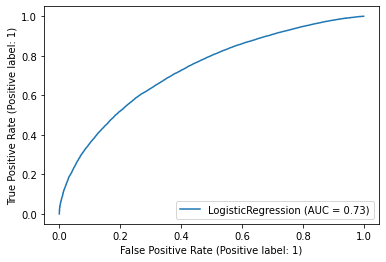

In [15]:
# Import the roc_curve function in sklearn

from sklearn.metrics import  roc_curve, auc, plot_roc_curve

# The ROC function returns the false-positive rates, the false-negative rates, and the thresholds t that compute the fpr and fnr.
fpr,tpr,thresholds = roc_curve(y_train, prob_pred[:,1])
roc_auc =auc(fpr,tpr)

# Directly plot the ROC curve
plot_roc_curve(LR,X_train,y_train)


We will discuss the definition of the performance metric area under the curve (AUC) later in this document. Alternatively, we can directly plot the ROC curve using the ```matplotlib``` package.

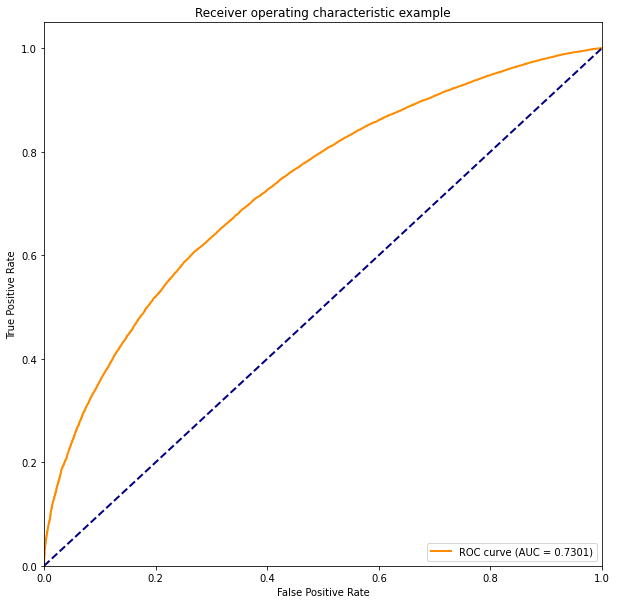

In [16]:
import matplotlib.pyplot  as plt
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


### (Optional)
Finally, if you want to add the threshold values $t$ onto the ROC curve. For this course, no need to pay attention to this code. You may go to [this link](https://gist.github.com/podshumok/c1d1c9394335d86255b8) for the code source.

In [17]:
#Adapted from: https://gist.github.com/podshumok/c1d1c9394335d86255b8
import numbers


import six

import numpy
import matplotlib.collections
from matplotlib import pyplot

# using example from
# http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb


def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates,
    in the correct format for LineCollection:
    an array of the form
    numlines x (points per line) x 2 (x and y) array
    '''

    points = numpy.array([x, y]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)

    return segments


def colorline(x, y, z=None, axes=None,
              cmap=pyplot.get_cmap('coolwarm'),
              norm=pyplot.Normalize(0.0, 1.0), linewidth=3, alpha=1.0,
              **kwargs):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = numpy.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if isinstance(z, numbers.Real):
        z = numpy.array([z])

    z = numpy.asarray(z)

    segments = make_segments(x, y)
    lc = matplotlib.collections.LineCollection(
        segments, array=z, cmap=cmap, norm=norm,
        linewidth=linewidth, alpha=alpha, **kwargs
    )

    if axes is None:
        axes = pyplot.gca()

    axes.add_collection(lc)
    axes.autoscale()

    return lc


def plot_roc(tpr, fpr, thresholds, subplots_kwargs=None,
             label_every=None, label_kwargs=None,
             fpr_label='False Positive Rate',
             tpr_label='True Positive Rate',
             luck_label='Luck',
             title='Receiver operating characteristic',
             **kwargs):

    if subplots_kwargs is None:
        subplots_kwargs = {}

    figure, axes = pyplot.subplots(1, 1, **subplots_kwargs)

    if 'lw' not in kwargs:
        kwargs['lw'] = 1

    axes.plot(fpr, tpr, **kwargs)

    if label_every is not None:
        if label_kwargs is None:
            label_kwargs = {}

        if 'bbox' not in label_kwargs:
            label_kwargs['bbox'] = dict(
                boxstyle='round,pad=0.5', fc='yellow', alpha=0.5,
            )

        for k in six.moves.range(len(tpr)):
            if k % label_every != 0:
                continue

            threshold = str(numpy.round(thresholds[k], 2))
            x = fpr[k]
            y = tpr[k]
            axes.annotate(threshold, (x, y), **label_kwargs)

    if luck_label is not None:
        axes.plot((0, 1), (0, 1), '--', color='Gray', label=luck_label)

    lc = colorline(fpr, tpr, thresholds, axes=axes)
    figure.colorbar(lc)

    axes.set_xlim([-0.05, 1.05])
    axes.set_ylim([-0.05, 1.05])

    axes.set_xlabel(fpr_label)
    axes.set_ylabel(tpr_label)

    axes.set_title(title)

    axes.legend(loc="lower right")

    return figure, axes

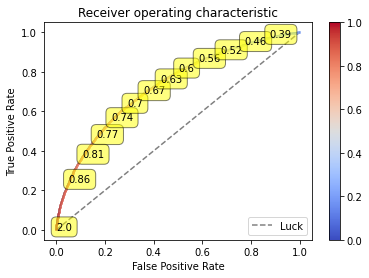

In [18]:
plt = plot_roc(tpr,fpr,thresholds, label_every=2000)

## 4.2. Area under the ROC Curve 

An important application of the ROC curve is measuring the fitniess/performance of a model for classification by the **area under the ROC curve (AUC)**. Specifically, the AUC is the total area under the ROC curve. The economic/physical interpretation of this model is that:

- Given one randome positive outcome and one random negative outcome, AUC is the probability that the model correctly predicts which outcome is positive and which outcome is negative.

AUC=1 refers to the case where the model makes a perfect prediction (in this case, the ROC curve is very close to the point $(0,1)$) whereas AUC=0.5 means that the model is making pure random guesses (in this case, the ROC curve is the straight line between $(0,0)$ and $(1,1)$). 

Compared with the overall accuracy measure, AUC is a more robust metric to evaluate a model, especially when the data is imbalanced (i.e., one of the outcomes is very scarce). For example, if there are 20 positive outcomes ($Y=1$) and 9980 negative outcomes ($Y=0$) in the data sample (which is likely to happen for a lot of rare diseases). In this case, regardless of the feature, a model that always predicts $Y=0$ will have an overall accuracy of $99.8\%$. But this model would fail to detect the rare positive cases, which is much more important than the overall accuracy. The AUC metric, however, would perform much better in this case by accurately detecting these positive outcomes.

We now compute the AUC for our logistic regression model trained on the Kwai retention data. 

In [20]:
print("The in-sample AUC is {:.4f}.".format(roc_auc))

The in-sample AUC is 0.7301.


<a id='section_5'></a>
# 5. Out-of-Sample Performance Evaluation

The logistic regression model can also be validated using the out-of-sample performance metrics with the testing set. Specifically, we could apply the fitted logistic regression model $\hat g(X_i)=\frac{\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}{1+\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}$ and the classifier $\hat f(X_i):= 1\{\hat g(X_i)\ge t\}=\begin{cases}
1,\mbox{ if }\hat g(X_i)\ge t\\
0,\mbox{ if }\hat g(X_i)< t
\end{cases}$ to the testing set $\mathcal D_{te}$.

To construct the out-of-sample confusion matrix, it suffices to change the in-sample prediction to the out-of-sample prediction by adjusting the data to the validation set.

In [21]:
prob_test =  LR.predict_proba(X_test)
# Set the threshold t=0.7
y_pred_test = list(map(lambda x: int(x>=0.7), prob_test[:, 1]))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=6462  |fp=2634     
-----------------------------
1        |fn=7731  |tp=13173    


The out-of-sample performance metrics can then be obtained directly from the confusion matrix above, and is left as a after-class exercise.

Next, we plot the out-of-sample ROC curve using the testing set, which is very similar to plotting the in-sample ROC curve with actual outcomes in the testing set and the predicted probabilities based on features in the testing set. 

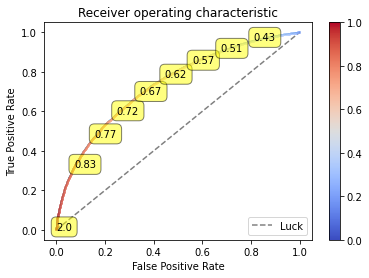

In [22]:
# Plot out-of-sample ROC curve

fpr,tpr,thresholds = roc_curve(y_test, prob_test[:,1])

plt = plot_roc(tpr,fpr,thresholds, label_every=1200)


Finally, we calculate the out-of-sample AUC based on the ROC curve plotted using the validation set.

In [23]:
#Out-of-sample AUC
roc_auc =auc(fpr,tpr)
print("The out-of-sample AUC is {:.4f}.".format(roc_auc))

The out-of-sample AUC is 0.7376.


<a id='section_6'></a>
# 6. Latent Variable Interpretation

An alternative interpretation of the logistic regression model is the so called latent variable interpretation. Specifically, for each data point $i$, there is an associated latent (unobservable) variable $Z_i$, which follows a distribution with the sigmoid function as $S(z)$ the cumulative distribution function (CDF, see [Wiki Page](https://en.wikipedia.org/wiki/Cumulative_distribution_function)), i.e.,

$$\mathbb P[Z_i\le z]=S(z)=\frac{\exp(z)}{1+\exp(z)}$$

The label of data point $i$, $Y_i$ is determined as follows:

$$Y_i=\begin{cases}
1,\mbox{ if }\beta_0+\sum_{j=1}^p\beta_jX_{ij}\ge Z_i\\
0,\mbox{ if }\beta_0+\sum_{j=1}^p\beta_jX_{ij}< Z_i
\end{cases}
$$

It follows from the construction that 
$$\mathbb P[Y_i=1|X_i]=\mathbb{P}\left[Z_i\le \beta_0+\sum_{j=1}^p\beta_jX_{ij}|X_i\right]=\frac{\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}$$

Therefore, the data is generated from the logistic regression model.

This interpretation naturally fits the customer purchasing choice context. Sepcifically, there is a single feature $X_{i1}$ which is the price of the product. $Z_i$ is the latent willingness-to-pay of customer $i$ for the product. Then, customer $i$ will purchase the product if and only if $Z_i> X_{i1}$, which is equivalent to the case where $Y_i=0$. Thus, the probability that a customer will not make a purchase (the case $Y_i=1$) is given by:

$$\mathbb P[Y_i=1|X_i]=\frac{\exp(X_{i1})}{1+\exp(X_{i1})}$$

#   7. Logistic Regression as a Linear Classifier

One should note that the logistic regression model will lead to a linear classifier. Specifically, the prediction rule that we predict $Y_i=1$ whenever

$$\hat{\mathbb P}[Y_i=1|X_i]=\frac{\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}{1+\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}\ge t$$ 

which is equivalent to that we predict $Y_i=1$ whenever $\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij}\ge t'$ where $t'\in(-\infty,+\infty)$ is a threshold satisfying 

$$t=\frac{\exp(t')}{1+\exp(t')}$$

Actually, $t'=\log(\frac{t}{1-t})$ for any $t\in(0,1)$. A linear classifier is illustrated in the following figure:

<img src="linearclassification.png" width=500>


A key advantage of the generalized linear nature of the logistic regression model is that it highlights the tradeoff between different features of interest. Specifically, the relative weight of the features can be captured by the ratio between their coefficients. For example, the estimated coefficients of the logistic regression model to predict user retention at Kwai are:

<a id='section_8'></a>
# 8. Logistic Regression Based Performance Metric and Bact-test

In [24]:
# Store the coefficients
df_coeff = pd.DataFrame({
    'Feature': ['h_video','f_video','f_live','n_video','n_live','comment_duration','comment_num'], 
    'Coefficient': np.array(LR.coef_).reshape(7)
})
#The estimated coefficients

df_coeff

,Feature,Coefficient
0,h_video,0.005684
1,f_video,0.012307
2,f_live,0.006375
3,n_video,0.017242
4,n_live,0.011922
5,comment_duration,0.008946
6,comment_num,0.019341


Then, we can normalize the coefficients by scaling the coefficient the coefficient of h_video to 1 and keeping their relative weight unchanged.

In [25]:
c = LR.coef_[0,0]
# Normalize the coefficients by that of h_video
df_coeff['Coef_Norm'] = df_coeff['Coefficient']/c
df_coeff

,Feature,Coefficient,Coef_Norm
0,h_video,0.005684,1.000000
1,f_video,0.012307,2.165240
2,f_live,0.006375,1.121659
3,n_video,0.017242,3.033469
4,n_live,0.011922,2.097501
5,comment_duration,0.008946,1.573906
6,comment_num,0.019341,3.402723


With these weight, we can understand the tradeoff between different (short-term) consumption metrics. For example, watching 1 minute of video on the follow page would be equivalent to watching 2.17 minutes hot-page video. Thus, our logistic regression model offers the insights that, for example, a new recommendation strategy that increases the follow page video time by 1 million minutes but decreases the hot page video time by 1.5 million minutes would still benefit the platform from the long-term retention's perspective, because the former is worth 2.17 million minutes of hot page video time. Inspired by the logistic regression model, we define the following metric for a group of users, called the score: 

-----

<font color=red>

$$S = hv+2.17fv+1.12fl+3.03nv+2.10nl+1.57cd+3.40cn,$$

</font>

-----

where

- $hv=$the total hot page video time (in minutes) of all users in the group;
- $fv=$the total follow page video time (in minutes) of all users in the group;
- $fl=$the total follow page live time (in minutes) of all users in the group;
- $nv=$the total nearby page video time (in minutes) of all users in the group;
- $nl=$the total nearby page live time (in minutes) of all users in the group;
- $cd=$the total comment duration time (in minutes) of all users in the group;
- $cm=$the total number of comments of all users in the group.

## 8.2. A/B Testing Based Back-test

Besides the usual out-of-sample metrics, the back-test based on A/B tests could also be adopted to evaluate the accuracy of the model. Here, we only give a brief introduction of the rationale and more details will be discussed as we study online A/B tests towards the end of this course. 

We first give a very brief introduction of A/B testing (a.k.a., randomized experiment) for online platforms. Thanks to the Internet technology, unprecedentedly large scale randomized experiments are taking place each day, by Tech giants such as Google, Facebook, Kwai, Alibaba, etc. Such platforms generally simultaneously run thousands of experiments everyday, influencing billions of platform users. A typical context for A/B testing is when the platform wants to examine whether a new product feature/user interface (UI)/algorithm is better than the benchmark. This is implemented in the following manner: Randomly assign users into the treatment group (new strategy applied) and the control group (baseline strategy applied). This is the **only difference** between these two groups. 

The following figure illustrates a typical. A platform wants so examine which of the following UI designs is better for the platform:

- Design A: An orange button on the right of a page;
- Design B: A blue button on the left of a page.

The platform randomly assigns its users into two groups, the first group (called the control group, 50% of the users) with Design A and the second group (called the treatment group, 50% of the users) with Design B.

<img src="AB1.png" width=500>

To evaluate Design A and Design B, we compare the outcomes (i.e., the conversion rates) of the treatment group and the control group. The difference (40% for the treatment group vs. 20% for the control group) measures the effectiveness of the new strategy (here Design B). 

We now discuss how to use A/B testing to evaluate whether the score/metric based on logistic regression is valid. Specifically, consider an A/B test on the platform where a random set of users belong to group $A$ and another random set of users belong to group $B$. Group $A$ and group $B$ are displayed with different UI designs. Assume that both groups have the same number of users: $N=N_A=N_B$ who are active on day $t$. Using the score discussed above, we can calculate the total weighted consumption of ALL users in group $i$ ($i=A,B$), denoted as $S_i$:

In [27]:
print("S_i=hv_i+{:.2f}fv_i+{:.2f}fl_i+{:.2f}nv_i+{:.2f}nl_i+{:.2f}cd_i+{:.2f}cn_i"\
      .format(df_coeff['Coef_Norm'].iloc[1],\
              df_coeff['Coef_Norm'].iloc[2],\
              df_coeff['Coef_Norm'].iloc[3],\
              df_coeff['Coef_Norm'].iloc[4],\
              df_coeff['Coef_Norm'].iloc[5],\
              df_coeff['Coef_Norm'].iloc[6]))

S_i=hv_i+2.17fv_i+1.12fl_i+3.03nv_i+2.10nl_i+1.57cd_i+3.40cn_i


We also denote the total number of the $N_i$ users in group $i$ who will also be active between day-$(t+28)$ and day-$(t+34)$ as $M_i$. Thus, the long-term (4-week) retention rate of the users in group $i$ will be 

<font color=red>
$$R_i=\frac{M_i}{N_i}.$$
</font>
    
By our logistic regression model, a higher score $S$ would be predictive for a higher retention rate. Therefore, if $S_A>S_B$ (respectively, $S_A<S_B$), we would expect that $R_A>R_B$ (respectively, $R_A<R_B$) as well by our model. Therefore, our model makes an accurate prediction if $S_A-S_B$ and $R_A-R_B$ have the same sign. If we have in total $K$ A/B tests, out of which our model makes a correct prediction in $K'$ of them, then the back-test accuracy of our logistic regression in predicting the long-term retention can be viewed as 

-----------------

<font color=red>
$$\mbox{Back-Test-Accuracy}=\frac{K'}{K}$$
</font>

------------------

# 9. Concluding Remarks

Logistic regression is arguably the **simplest** supervised learning model for classification (predicting a binary label). It assumes that probability of a positive lable follows the sigmoid function of a linear function of the features. The model fitting is based on the maximum likelihood estimation (MLE) of all training observations. We use the confusion matrix and ROC-AUC to evaluate the prediction accuracy of a logistic regression model. The decision threshold $t$ for predicting a positive label trades off the false-positive rate and the false-negative rate. Logistic regression is essentially a linear classifier and bears a natural construction of a metric that predicts long-term retention with more sensitive short-term consumption measures. 